# Projekt ML: Predykcja Popularności Utworów Spotify
## Etap 2: Inżynieria Cech i weryfikacja pipeline'u
**Autor:** Grzegorz Zioło

### 1. Wprowadzenie
Poprzedni etam (EDA) pokazał naturę danych, odkrywając m.in. bimodalność zmiennej celu czy problem dużej liczby gatunków muzycznych.

Celem tego notatnika jest inżynieria cech.

Moim celem jest weryfikacja krok po kroku, jak surowe informacje z pliku CSV są zamieniane na macierze matematyczne.

#### Cele Notatnika
Ten etap służy jako laboratorium techniczne przed właściwym modelowaniem.

1. Sprawdzenie poprawność usuwanych kolumn o wysokiej kardynalności (np. `track_name`, `track_id`), które w poprzednich próbach powodowały błędy pamięci.
2. Analiza Transformacji:
    * Zmienne Numeryczne - Czy `StandardScaler` poprawnie sprowadził cechy (np. `loudness`, `duration_ms`) do rozkładu o średniej 0 i odchyleniu 1?
    * Zmienne Kategoryczne - Jak wygląda macierz po zastosowaniu `OneHotEncoder` dla kolumny `track_genre`?
    * Zmienne Binarne - Czy flaga `explicit` została poprawnie zmapowana?
3.  Kontrola Wymiarowości:
    * Upewnienie się, że finalna liczba cech (kolumn) jest optymalna dla modelu `XGBoost` i nie wprowadzamy szumu.

#### Wykorzystane Narzędzia
Korzystam z autorskich klas zaimplementowanych w module `src`:
* `SpotifyDataCleaner`: do usuwania duplikatów i zbędnych metadanych.
* `SpotifyPipelinePreprocessor`: do budowy potoku transformacji Scikit-Learn (`ColumnTransformer`).

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Dodanie ścieżki do src
sys.path.append(os.path.abspath('..'))

from src.loaders import DataLoaderFactory
from src.cleaners import SpotifyDataCleaner
from src.preprocessors import SpotifyPipelinePreprocessor

### 1. Ładowanie i Wstępne Czyszczenie Danych

Rozpoczynam od pobrania surowego zbioru danych i przepuszczenia go przez moduł czyszczący `SpotifyDataCleaner`.

**Kluczowe aspekty weryfikacji:**
1. Czy kolumny tekstowe o wysokiej liczbie unikalnych wartości (`track_id`, `track_name`, `album_name`, `artists`) zostały usunięte? Ich obecność w etapie One-Hot Encodingu powodowała eksplozję zużycia pamięci RAM (>60GB).
2. Czy duplikaty oraz rekordy z brakującymi danymi zostały odfiltrowane?
3. Czy DataFrame zawiera wyłącznie te cechy, które niosą ze sobą uogólnialną informację (cechy audio + gatunek)?

Wnioski z tego kroku potwierdzą, czy pipeline jest bezpieczny pamięciowo i gotowy do skalowania.

In [11]:
# Pobranie i czyszczenie
loader = DataLoaderFactory.get_loader("hf://datasets/maharshipandya/spotify-tracks-dataset/dataset.csv")
raw_df = loader.load()

print(f"Dane przed czyszczeniem. Kształt: {raw_df.shape}")
raw_df.head(3)

Dane przed czyszczeniem. Kształt: (114000, 21)


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.461,...,-6.746,0,0.1430,0.0322,0.000001,0.358,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.166,...,-17.235,1,0.0763,0.9240,0.000006,0.101,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.359,...,-9.734,1,0.0557,0.2100,0.000000,0.117,0.120,76.332,4,acoustic


In [14]:
# Czyszczenie danych
cleaner = SpotifyDataCleaner()
df = cleaner.clean(raw_df)
print(f"Dane po czyszczeniu. Kształt: {df.shape}")
df.head(3)

Dane po czyszczeniu. Kształt: (89741, 16)


,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,73,230666,0,0.676,0.461,1,-6.746,0,0.1430,0.0322,0.000001,0.358,0.715,87.917,4,acoustic
1,55,149610,0,0.420,0.166,1,-17.235,1,0.0763,0.9240,0.000006,0.101,0.267,77.489,4,acoustic
2,57,210826,0,0.438,0.359,0,-9.734,1,0.0557,0.2100,0.000000,0.117,0.120,76.332,4,acoustic


#### Weryfikacja

##### Weryfikacja bezpieczeństwa pamięci.
Czy niebezpieczne kolumny (tekstowe unikalne) zostały na pewno usunięte?

In [15]:
dangerous_cols = ['track_id', 'track_name', 'album_name', 'artists']
remaining_dangerous = [col for col in dangerous_cols if col in df.columns]

if not remaining_dangerous:
    print("SUKCES: Kolumny o wysokiej kardynalności (ID, nazwy) zostały poprawnie usunięte.")
else:
    print(f"BŁĄD: W zbiorze nadal znajdują się niebezpieczne kolumny: {remaining_dangerous}")

SUKCES: Kolumny o wysokiej kardynalności (ID, nazwy) zostały poprawnie usunięte.


##### Weryfikacja kolumn kategorycznych (do zakodowania)

In [21]:
df.select_dtypes(include=['object', 'category']).columns.tolist()

['track_genre']

#### Wnioski z czyszczenia
Tabela `df` jest przygotowana do transformacji. Usunięcie metadanych tekstowych zredukowało ryzyko przepełnienia pamięci, pozostawiając jedynie:
* Cechy Audio (liczbowe) niosące informację o charakterystyce dźwięku.
* Gatunek (`track_genre`) - jedyną zmienną kategoryczną, która zostanie zamieniona na wektor binarny.
* Explicit (`explicit`) - zmienną binarną.

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 89741 entries, 0 to 113999
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   popularity        89741 non-null  int64   
 1   duration_ms       89741 non-null  int64   
 2   explicit          89741 non-null  int64   
 3   danceability      89741 non-null  float64 
 4   energy            89741 non-null  float64 
 5   key               89741 non-null  int64   
 6   loudness          89741 non-null  float64 
 7   mode              89741 non-null  int64   
 8   speechiness       89741 non-null  float64 
 9   acousticness      89741 non-null  float64 
 10  instrumentalness  89741 non-null  float64 
 11  liveness          89741 non-null  float64 
 12  valence           89741 non-null  float64 
 13  tempo             89741 non-null  float64 
 14  time_signature    89741 non-null  int64   
 15  track_genre       89741 non-null  category
dtypes: category(1), float64(9)

### 2. Uruchomienie Preprocessora

W tym kroku uruchamiam klasę `SpotifyPipelinePreprocessor`, która automatyzuje trzy kluczowe rzeczy:
1. Podział (Split) - Dane są dzielone na zbiór treningowy i testowy (chronimy się przed wyciekiem danych).
2. Imputacja (Imputation) - Braki danych są uzupełniane (mediana dla liczb, moda dla kategorii).
3. Transformacja:
   * Liczby są skalowane (`StandardScaler`).
   * Gatunki są zamieniane na wektory (`OneHotEncoder`).

Spodziewam się, że wymiarowość danych (liczba kolumn) wzrośnie z kilkunastu do ponad stu (przez rozwinięcie gatunków), ale nie do tysięcy.

In [36]:
# Inicjalizacja preprocessora
preprocessor = SpotifyPipelinePreprocessor(target_col='popularity', test_size=0.2)

# Uruchomienie procesu (Fit & Transform)
X_train, X_test, y_train, y_test = preprocessor.process(df)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape:  {X_test.shape}")

print("\nPrzykładowy wiersz:")
print(X_train[0][:10])

X_train shape: (71792, 127)
X_test shape:  (17949, 127)

Przykładowy wiersz:
[-0.03116764 -0.30712134  0.01691534 -0.65290807 -0.0792155   0.14593404
 -1.32316164 -0.34373707  0.9297276  -0.5367788 ]


### 3. Dekodowanie i Weryfikacja Wyników (Inspection)

Weryfikacja operacji wykonanych przez preprocessor:
1. Poprawność One-Hot Encodingu - Czy kolumna `track_genre` zniknęła, a w jej miejsce pojawiły się kolumny typu `track_genre_pop`, `track_genre_rock` itd.?
2. Poprawność Skalowania - Czy cechy numeryczne (np. `loudness`, `tempo`) mają teraz wartości oscylujące wokół zera (dodatnie i ujemne), co świadczy o zadziałaniu `StandardScaler`?

In [37]:
# Pobranie nazw cech z pipeline'u
feature_names = preprocessor.get_feature_names()

print(f"Liczba nazw cech: {len(feature_names)}")
print(f"Przykładowe cechy: {feature_names[:5]} ... {feature_names[-5:]}")

Liczba nazw cech: 127
Przykładowe cechy: ['duration_ms', 'explicit', 'danceability', 'energy', 'key'] ... ['track_genre_techno', 'track_genre_trance', 'track_genre_trip-hop', 'track_genre_turkish', 'track_genre_world-music']


In [38]:
# Rekonstrukcja DataFrame
X_train_df = pd.DataFrame(X_train, columns=feature_names)

# Wyświetlenie próbki
X_train_df.head(3)

,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,track_genre_spanish,track_genre_study,track_genre_swedish,track_genre_synth-pop,track_genre_tango,track_genre_techno,track_genre_trance,track_genre_trip-hop,track_genre_turkish,track_genre_world-music
0,-0.031168,-0.307121,0.016915,-0.652908,-0.079216,0.145934,-1.323162,-0.343737,0.929728,-0.536779,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.254081,-0.307121,-2.343117,1.338204,0.201598,0.856036,-1.323162,0.876306,-0.969089,-0.536521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.389077,-0.307121,-0.820698,1.194033,-0.360029,0.988667,0.755766,-0.282074,-0.966385,-0.536513,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


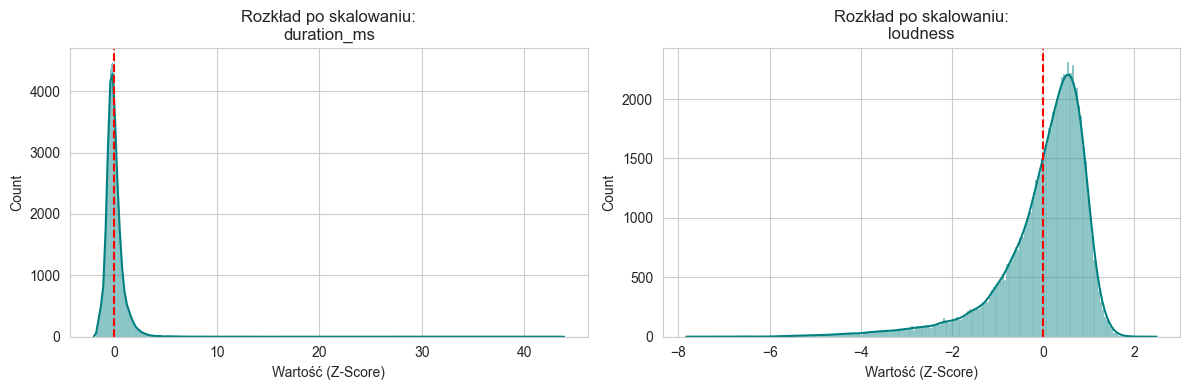

In [39]:
# Wizualna weryfikacja skalowania dla kluczowych cech audio
cols_to_plot = [col for col in feature_names if 'loudness' in col or 'duration' in col]

if cols_to_plot:
    plt.figure(figsize=(12, 4))
    for i, col in enumerate(cols_to_plot[:2]):
        plt.subplot(1, 2, i+1)
        sns.histplot(X_train_df[col], kde=True, color='teal')
        plt.title(f'Rozkład po skalowaniu:\n{col}')
        plt.xlabel('Wartość (Z-Score)')
        plt.axvline(0, color='red', linestyle='--')
    plt.tight_layout()
    plt.show()
else:
    print("Nie znaleziono kolumn numerycznych do wyrysowania.")

In [40]:
# Weryfikacja gatunków
genre_cols = [c for c in feature_names if 'track_genre' in c]
if genre_cols:
    print(f"\nZnaleziono {len(genre_cols)} zakodowanych gatunków.")
    print("Przykładowy fragment macierzy gatunków:")
    display(X_train_df[genre_cols].iloc[:5, :5])

    # Sprawdzenie, czy wartości to tylko 0.0 i 1.0
    unique_vals = np.unique(X_train_df[genre_cols].values)
    print(f"Unikalne wartości w kolumnach gatunków: {unique_vals} (Powinno być tylko 0. i 1.)")


Znaleziono 113 zakodowanych gatunków.
Przykładowy fragment macierzy gatunków:


,track_genre_acoustic,track_genre_afrobeat,track_genre_alt-rock,track_genre_alternative,track_genre_ambient
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0


Unikalne wartości w kolumnach gatunków: [0. 1.] (Powinno być tylko 0. i 1.)


### 4. Podsumowanie i Wnioski

Weryfikacja procesu Feature Engineeringu zakończyła się sukcesem.

**Kluczowe obserwacje:**
1. Histogramy potwierdzają, że cechy numeryczne zostały przetransformowane do rozkładu o średniej ~0. Dzięki temu algorytmy gradientowe będą zbiegać szybciej i stabilniej.
2. Po zastosowaniu One-Hot Encodingu liczba kolumn wynosi 127. Jest to liczba bezpieczna obliczeniowo.
3. Macierze `X_train` i `X_test` są gotowe do przekazania do modelu.